In [107]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [108]:
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [109]:
num_skipped = 0

for folder_name in ('Cat', 'Dog'):
    file_path = os.path.join("datasets", "PetImages", folder_name)
    for file in os.listdir(file_path):
        fpath = os.path.join(file_path, file)
        with open(fpath, "rb") as file_name:
            is_jfif = b"JFIF" in file_name.peek(10)
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"{num_skipped} of images are removed")

0 of images are removed


In [135]:
image_size = (100, 100)
batch_size = 100

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "datasets/PetImages",
    validation_split=0.2,
    subset="both",
    seed=133,
    label_mode="binary",
    image_size=image_size,
    batch_size=batch_size,
)

Found 183 files belonging to 2 classes.
Using 147 files for training.
Using 36 files for validation.


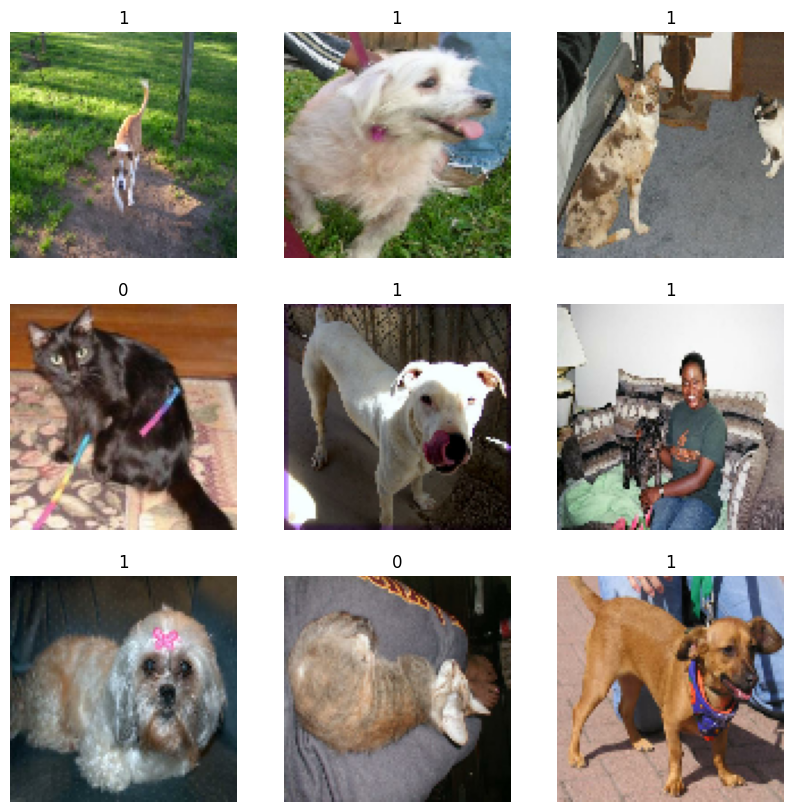

In [137]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis('off')

In [139]:
data_augmentation_layer = [
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
]

def augmentation_images(images):
    for layer in data_augmentation_layer:
        images = layer(images)
    return images

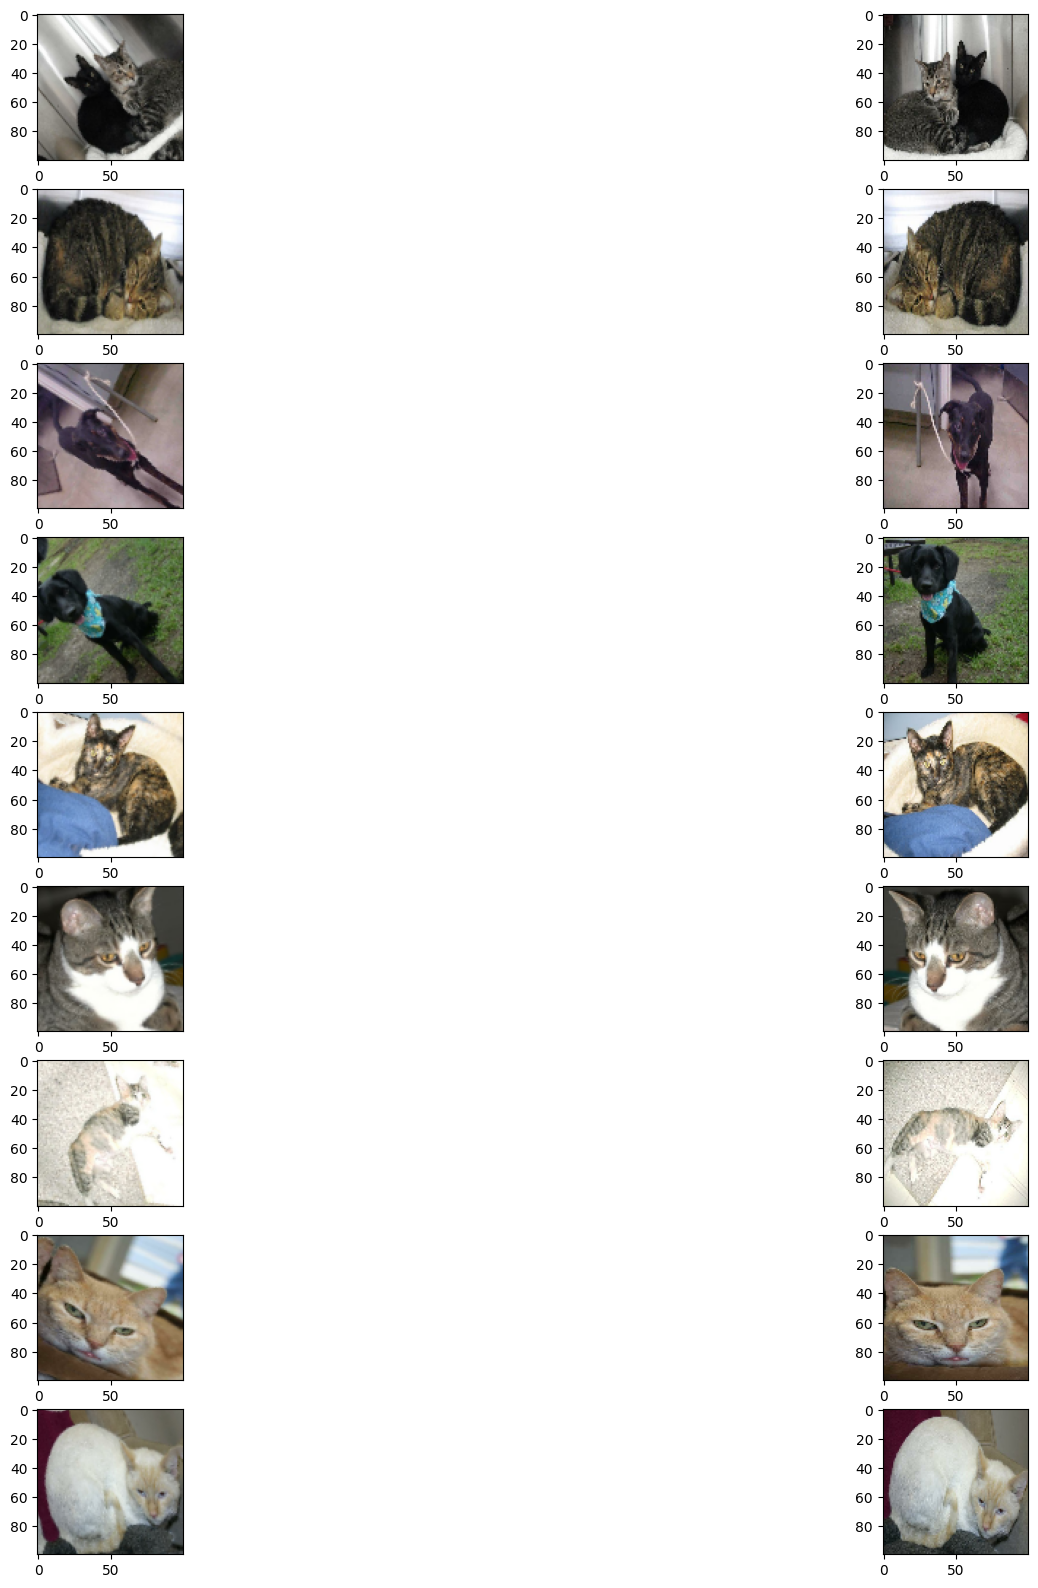

In [140]:
# make augmentation img and see the diff
fig, axs = plt.subplots(9,2)
fig.set_figwidth(20)
fig.set_figheight(20)

for images, _ in train_ds.take(1):
    for i in range(9):
        augmentated_img = augmentation_images(images)
        axs[i, 0].imshow(np.array(augmentated_img[i]).astype("uint8"))
        axs[i, 1].imshow(np.array(images[i]).astype("uint8"))

In [142]:
# map dataset
train_ds = train_ds.map(
    lambda img, label: (augmentation_images(img), label),
    num_parallel_calls=tf_data.AUTOTUNE # improve the performance
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [155]:
def make_model(input_shape, num_classes):
        
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs) # normalize the input data
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [25, 50, 100]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(100, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

In [144]:
model = make_model(input_shape=image_size + (3, ), num_classes=2)

In [146]:
epochs = 5

# save each epoch
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryCrossentropy(name="acc")],
)

model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_35        │ (None, 100, 100,  │          0 │ input_layer_23[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 50, 50,    │      3,584 │ rescaling_35[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_136      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 50, 50,    │          0 │ activation_136[0… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 50, 50,    │      4,377 │ activation_137[0… │
│ (SeparableConv2D)   │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        100 │ separable_conv2d… │
│ (BatchNormalizatio… │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_138      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 50, 50,    │        875 │ activation_138[0… │
│ (SeparableConv2D)   │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        100 │ separable_conv2d… │
│ (BatchNormalizatio… │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 25, 25,    │      3,225 │ activation_136[0… │
│                     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 25, 25,    │          0 │ max_pooling2d_45… │
│                     │ 25)               │            │ conv2d_81[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_139      │ (None, 25, 25,    │          0 │ add_46[0][0]      │
│ (Activation)        │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 25, 25,    │      1,525 │ activation_139[0… │
│ (SeparableConv2D)   │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        200 │ separable_conv2d

 Total params: 52,949 (206.83 KB)

 Trainable params: 51,793 (202.32 KB)

 Non-trainable params: 1,156 (4.52 KB)

In [148]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - acc: 5.0432 - loss: 0.7557 - val_acc: 8.5068 - val_loss: 0.6933
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 905ms/step - acc: 4.4349 - loss: 0.6922 - val_acc: 8.5068 - val_loss: 0.6933
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 917ms/step - acc: 3.8907 - loss: 0.6473 - val_acc: 8.5068 - val_loss: 0.6934
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 898ms/step - acc: 4.2598 - loss: 0.6420 - val_acc: 8.5068 - val_loss: 0.6934
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 892ms/step - acc: 3.6758 - loss: 0.6276 - val_acc: 8.5068 - val_loss: 0.6936


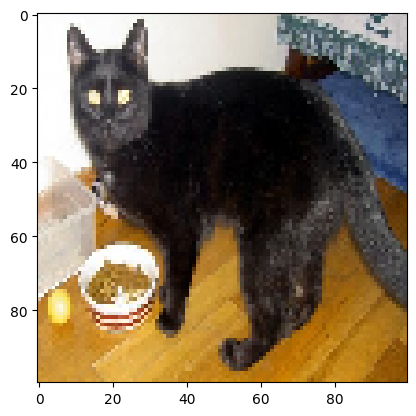

In [150]:
img = keras.utils.load_img("datasets/PetImages/Cat/79.jpg", target_size=image_size)
plt.imshow(img)

In [154]:
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # extend the shape along the axis 0

(100, 100, 3)
(1, 100, 100, 3)


In [152]:
predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
This image is 50.38% cat and 49.62% dog.
